In [2]:
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Linear regression using the Normal Equation

In [3]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [28]:
X.shape, y.shape

((100, 1), (100, 1))

In [7]:
X[:3, :]

array([[0.74908024],
       [1.90142861],
       [1.46398788]])

In [10]:
y[:3]

array([[6.33428778],
       [9.40527849],
       [8.48372443]])

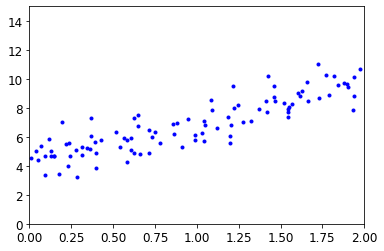

In [20]:
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.show()

In [22]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance

In [24]:
X_b.shape

(100, 2)

In [25]:
X_b[:3]

array([[1.        , 0.74908024],
       [1.        , 1.90142861],
       [1.        , 1.46398788]])

The function that we below used to generate the data is $y = 4 + 3x_1 +$ *Gaussian noise*. Let’s see what the equation found:

In [26]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [27]:
theta_best

array([[4.21509616],
       [2.77011339]])

We would have hoped for $θ_0 = 4$ and $θ_1 = 3$ instead of $θ_0 = 4.215$ and $θ_1 = 2.770$. Close enough, but the noise made it impossible to recover the exact parameters of the original function.

Now we can make predictions using 
θ^:

In [30]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)

In [31]:
y_predict

array([[4.21509616],
       [9.75532293]])

Let’s plot this model’s predictions:

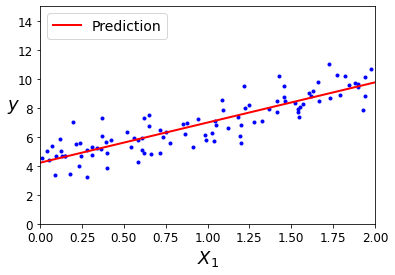

In [38]:
plt.plot(X, y, 'b.')
plt.plot(X_new, y_predict, 'r-', linewidth=2, label='Prediction')
plt.axis([0, 2, 0, 15])
plt.xlabel('$X_1$', fontsize=18)
plt.ylabel('$y$', fontsize=18, rotation=0)
plt.legend(loc='upper left', fontsize=14)
plt.show()

# Performing Linear Regression using Scikit-Learn

In [39]:
from sklearn.linear_model import LinearRegression

In [40]:
LinearRegression??

Init signature:
LinearRegression(
    *,
    fit_intercept=True,
    normalize=False,
    copy_X=True,
    n_jobs=None,
)
Source:        
class LinearRegression(MultiOutputMixin, RegressorMixin, LinearModel):
    """
    Ordinary least squares Linear Regression.

    LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
    to minimize the residual sum of squares between the observed targets in
    the dataset, and the targets predicted by the linear approximation.

    Parameters
    ----------
    fit_intercept : bool, default=True
        Whether to calculate the intercept for this model. If set
        to False, no intercept will be used in calculations
        (i.e. data is expected to be centered).

    normalize : bool, default=False
        This parameter is ignored when ``fit_intercept`` is set to False.
        If True, the regressors X will be normalized before regression by
        subtracting the mean and dividing by the l2-norm.
        If you wish to s

In [41]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [42]:
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [43]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for “**least squares**”), which you could call directly:

In [44]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)

In [45]:
theta_best_svd

array([[4.21509616],
       [2.77011339]])

In [49]:
residuals, rank, s

(array([80.6584564]), 2, array([14.37020392,  4.11961067]))

This function computes $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the _pseudoinverse_ of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [50]:
np.linalg.pinv(X_b).dot(y) # pseudoinverse of X_b

array([[4.21509616],
       [2.77011339]])

The pseudoinverse itself is computed using a standard matrix factorization technique called **_Singular Value Decomposition (SVD)_** 

# Computational Complexity

The Normal Equation computes the inverse of $X^⊺ X$, which is an $(n + 1) × (n + 1)$ matrix (where $n$ is the number of features). The computational complexity of inverting such a matrix is typically about $O(n^{2.4})$ to $O(n^3)$, depending on the implementation. In other words, if you double the number of features, you multiply the computation time by roughly $2^{2.4} = 5.3$ to $2^3 = 8$.

The SVD approach used by Scikit-Learn’s `LinearRegression` class is about $O(n^2)$. `If you double the number of features, you multiply the computation time by roughly 4.`

# **`WARNING`**

> **Both the Normal Equation and the SVD approach get very slow when the number of features grows large (e.g., 100,000). On the positive side, both are linear with regard to the number of instances in the training set (they are O(m)), so they handle large training sets efficiently, provided they can fit in memory.**

Also, once you have trained your Linear Regression model (using the Normal Equation or any other algorithm), `predictions are very fast`: the computational complexity is linear with regard to both the number of instances you want to make predictions on and the number of features. In other words, making predictions on twice as many instances (or twice as many features) will take roughly twice as much time.

Now we will look at a very different way to train a Linear Regression model, which is better suited for cases where there are a large number of features or too many training instances to fit in memory.

# Gradient Descent

Gradient Descent is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of Gradient Descent is to tweak parameters iteratively in order to minimize a cost function.

An important parameter in Gradient Descent is the size of the steps, determined by the `learning rate hyperparameter`. <br>
If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time. <br>
On the other hand, if the learning rate is too high, you might jump across the valley and end up on the other side, possibly even higher up than you were before. This might make the algorithm diverge, with larger and larger values, failing to find a good solution

Finally, not all cost functions look like nice, regular bowls. There may be holes, ridges, plateaus, and all sorts of irregular terrains, making convergence to the minimum difficult. Below figure shows the two main challenges with Gradient Descent. If the random initialization starts the algorithm on the left, then it will converge to a local minimum, which is not as good as the global minimum. If it starts on the right, then it will take a very long time to cross the plateau. And if you stop too early, you will never reach the global minimum.

![Gradient Descent Pitfalls](images/training_linear_models/gradient_descent_pitfalls.png)

Fortunately, `the MSE cost function for a Linear Regression model happens to be a convex function`, which means that if you pick any two points on the curve, the line segment joining them never crosses the curve. This implies that there are `no local minima, just one global minimum`. It is also a continuous function with a slope that never changes abruptly. These two facts have a great consequence: `Gradient Descent is guaranteed to approach arbitrarily close the global minimum` (if you wait long enough and if the learning rate is not too high).

**`In fact, the cost function has the shape of a bowl, but it can be an elongated bowl if the features have very different scales. Below Figure shows Gradient Descent on a training set where features 1 and 2 have the same scale (on the left), and on a training set where feature 1 has much smaller values than feature 2 (on the right).`**

![Gradient Descent with (left) and without (right) feature scaling](images/training_linear_models/gradient_descent_feature_scaling.png)

As you can see, on the left the Gradient Descent algorithm goes straight toward the minimum, thereby reaching it quickly, whereas on the right it first goes in a direction almost orthogonal to the direction of the global minimum, and it ends with a long march down an almost flat valley. It will eventually reach the minimum, but it will take a long time.

## **`WARNING`**

> `When using Gradient Descent, you should ensure that all features have a similar scale (e.g., using Scikit-Learn’s StandardScaler class), or else it will take much longer to converge.`

# Batch Gradient Descent

To implement Gradient Descent, you need to compute the gradient of the cost function with regard to each model parameter $θ_j$. In other words, you need to calculate how much the cost function will change if you change $θ_j$ just a little bit. This is called a `partial derivative`. <br>
It is like asking “What is the slope of the mountain under my feet if I face east?” and then asking the same question facing north (and so on for all other dimensions, if you can imagine a universe with more than three dimensions).

# WARNING

> Notice that in a formula that involves calculations over the full training set X, at each Gradient Descent step is called `Batch Gradient Descent`: it uses the whole batch of training data at every step (actually, Full Gradient Descent would probably be a better name). <br>
As a result it is terribly slow on very large training sets (but we will see much faster Gradient Descent algorithms shortly). However, `Gradient Descent scales well with the number of features; training a Linear Regression model when there are hundreds of thousands of features is much faster using Gradient Descent than using the Normal Equation or SVD decomposition.`

Once you have the gradient vector, which points uphill, just go in the opposite direction to go downhill. This means subtracting $∇_θ MSE(θ)$ from $θ$. This is where the learning rate $η$ comes into play: `multiply the gradient vector by` $η$ `to determine the size of the downhill step` 

$$θ^{(next step)} = θ - η∇_θMSE(θ)$$

Let’s look at a quick implementation of this algorithm:

In [51]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1) # random initialization

In [52]:
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta -= eta*gradients

That wasn’t too hard! Let’s look at the resulting theta:

In [53]:
theta

array([[4.21509616],
       [2.77011339]])

In [56]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

Hey, that’s exactly what the Normal Equation found! Gradient Descent worked perfectly. But what if you had used a different learning rate $\eta$? Below Figures show the first 10 steps of Gradient Descent using three different learning rates (the dashed line represents the starting point).

In [98]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, 'b.')
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = 'b-' if iteration > 0 else 'r--'
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
        
    plt.xlabel("$X_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)
    

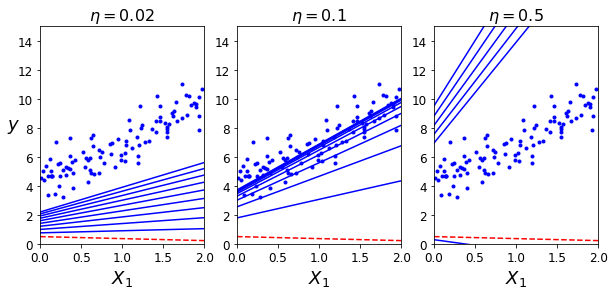

In [99]:
np.random.seed(42)

theta = np.random.randn(2, 1)

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132)
plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133)
plot_gradient_descent(theta, eta=0.5)
plt.show()

On the left, the learning rate is too low: the algorithm will eventually reach the solution, but it will take a long time. In the middle, the learning rate looks pretty good: in just a few iterations, it has already converged to the solution. On the right, the learning rate is too high: the algorithm diverges, jumping all over the place and actually getting further and further away from the solution at every step

**`To find a good learning rate, you can use grid search`** (see Chapter 2). **`However, you may want to limit the number of iterations so that grid search can eliminate models that take too long to converge.`**

You may wonder `how to set the number of iterations`. <br>
If it is too low, you will still be far away from the optimal solution when the algorithm stops; but if it is too high, you will waste time while the model parameters do not change anymore. <br>
**_A simple solution is to set a very large number of iterations but to interrupt the algorithm when the gradient vector becomes tiny—that is, when its norm becomes smaller than a tiny number `ϵ (called the tolerance)`—because this happens when Gradient Descent has (almost) reached the minimum._**

## CONVERGENCE RATE

> When the cost function is convex and its slope does not change abruptly (as is the case for the MSE cost function), Batch Gradient Descent with a fixed learning rate will eventually converge to the optimal solution, but you may have to wait a while: it can take $O(1/ϵ)$ iterations to reach the optimum within a range of ϵ, depending on the shape of the cost function. `If you divide the tolerance by 10 to have a more precise solution, then the algorithm may have to run about 10 times longer.`

# Stochastic Gradient Descent